In [43]:
import numpy as np
import matplotlib.pyplot as plt
import json # mark: add this line
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)

### Problem 2.2 (10 points): Exploring the Yelp Dataset

The Yelp dataset consists of millions of reviews with their scores (1 to 5), all available for public research. We will only use a subset of the reviews here. This review data can be used in a classification task, where we are given a review and we predict whether it is a positive or a negative review. We will consider a review as *negative* if it has a score $\leq 2$, or *positive* if it has a score $\geq 4$.

Below we pre-process the dataset for you using what's known as a bag-of-words approach. You will run the code create a bag of words (BOW) representation from text documents, using the Vectorizer function in scikit-learn to convert each text review (a string) to a fixed-length vector of numbers that we use as a feature vector for a classifier. 

Note that the details of how reviews are converted to vectors is not particularly important for you to follow in detail. What is important is to be aware that after we run the code below we will get a data matrix with n rows (one per review) and d features (where each of the d features corresponds to a different word). Each row in the data matrix is a feature vector for a Yelp review, where the values in the feature vector correspond to how often different words occur in the review.

In a bit more detail, the bag of words representation of text is a way to turn text (in the form of a string) into a vector of some fixed dimension. More specifically, every document (e.g., a review) is converted into a vector $\mathbf{x}$, where $\mathbf{x}_j$ denotes whether the $j$th word from the vocabulary list is used in the sentence. For example, if our vocabulary is `[he, she, his, her, loves, likes, dogs, cats, cute, nice]`, the sentence `"he loves cats and she loves dogs"` can be vectorized as `[1, 1, 0, 0, 2, 0, 1, 1, 0, 0]`. This representation allows us to compare documents (e.g., reviews) in the same way we have been doing with tabular data and images.



The inputs are 
- a filename (you will use "yelp_reviews.json") containing the reviews in JSON format (provided in the .zip file)
- the min_pos and max_neg parameters (use the default values.)

The outputs are
- **X**: Feature Matrix in compressed sparse row format.
    - $\textbf{X}$ is in shape of [# reviews, # terms in vocabulary]  (where #terms = #features)
    - $\textbf{X}_{ij}$ indicates the number of the $j$th term in the vocabulary existing in the $i$th review.
- **y**: Review label vector
- **text**: Raw reviews
- **vectorizer_BOW.vocabulary_**: A mapping of terms to feature indices, somes terms are excluded



**NOTE**: 
- please read the scikit-learn tutorial on text feature extraction before you start this problem: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction  (its fine to just read Sections 6.2.3.1 to 6.2.3.3)

In [2]:
def create_bow_from_reviews(filename, min_pos=4, max_neg=2): 
    
    print('Loading the file:', filename) 
    with open(filename, 'r') as jfile:
        data = json.load(jfile)
        
    print('Total number of reviews extracted =', len(data))

    text = []
    y = []
    print('Extracting tokens from each review.....(can be slow for a large number of reviews)......')   
    for d in data: 	# can substitute data[0:9] here if you want to test this function on just a few reviews 	
        review = d['text']     # keep only the text and label
        stars = int(d['stars'])
        if stars >= min_pos:   # represent scores > min_pos as "1"
            score = 1
        elif stars <= max_neg:  # represent scores < max_neg as "0"
            score = 0
        else: # do not consider reviews with scores above max_neg and below min_pos (these reviews will be dropped)
            continue  

        text.append(review)   
        y.append(score)
    
    # create an instance of a CountVectorizer, using 
    # (1) the standard 'english' stopword set 
    # (2) only keeping terms in the vocabulary that occur in at least 1% of documents
    # (3) allowing only unigrams in the vocabulary (use "ngram_range=(1, 1)" to do this)
    vectorizer = CountVectorizer(stop_words='english',min_df=0.02, ngram_range=(1, 1))

    # create a sparse BOW array from 'text' using vectorizer
    X = vectorizer.fit_transform(text)
 
    print('Data shape: ', X.shape)
    
    # you can uncomment this next line if you want to see the full list of tokens in the vocabulary  
    #print('Vocabulary: ', vectorizer.get_feature_names())

    return X, y, vectorizer, text

In [3]:
### How does the classifier work? (A more intuitive explanation)

In [62]:
'''
How the CountVectorizer works (with a short example) - Mark
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
'''
from sklearn.feature_extraction.text import CountVectorizer
corpus_temp = ['This is the first document',
          'This document is the second document',
          'And this is the third one.',
          'Is this the first document?',
          'Diego Diego Diego:)',
          'hyphen test: pre-trained model']
Vectorizer_temp = CountVectorizer()
X_temp = Vectorizer_temp.fit_transform(corpus_temp)


In [63]:
# sort by alphabet by default, with all words
Vectorizer_temp.get_feature_names_out()

array(['and', 'diego', 'document', 'first', 'hyphen', 'is', 'model',
       'one', 'pre', 'second', 'test', 'the', 'third', 'this', 'trained'],
      dtype=object)

In [64]:
'''
shape = (# of document, # of unique word)
Each row corresponds to a document - sum(row 1st) = # of words in row 1,
Each column corresponds to a unique word in the corpus,  sum(col 1st) = # of unique word in the whole dataset, 
The values in the matrix represent the count of each word in the corresponding document.
'''
print(X_temp.toarray())
'''
Interpret the first row (This is the first document):
"and" appears 0 time,
"document" appears 1 time,
"first" appears 1 time,
"is" appears 1 time,
"one" appears 1 time.
'''

[[0 0 1 1 0 1 0 0 0 0 0 1 0 1 0]
 [0 0 2 0 0 1 0 0 0 1 0 1 0 1 0]
 [1 0 0 0 0 1 0 1 0 0 0 1 1 1 0]
 [0 0 1 1 0 1 0 0 0 0 0 1 0 1 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 1 0 1 0 0 0 1]]


'\nInterpret the first row (This is the first document):\n"and" appears 0 time,\n"document" appears 1 time,\n"first" appears 1 time,\n"is" appears 1 time,\n"one" appears 1 time.\n'

In [65]:
# a more intuitive way to understand the table in previous chunk.
dense_matrix = pd.DataFrame(X_temp.toarray(), columns=Vectorizer_temp.get_feature_names_out())
dense_matrix

,and,diego,document,first,hyphen,is,model,one,pre,second,test,the,third,this,trained
0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0
1,0,0,2,0,0,1,0,0,0,1,0,1,0,1,0
2,1,0,0,0,0,1,0,1,0,0,0,1,1,1,0
3,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0
4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1


In [81]:
np.sum(X_temp > 0, axis=1)

matrix([[5],
        [5],
        [6],
        [5],
        [1],
        [5]])

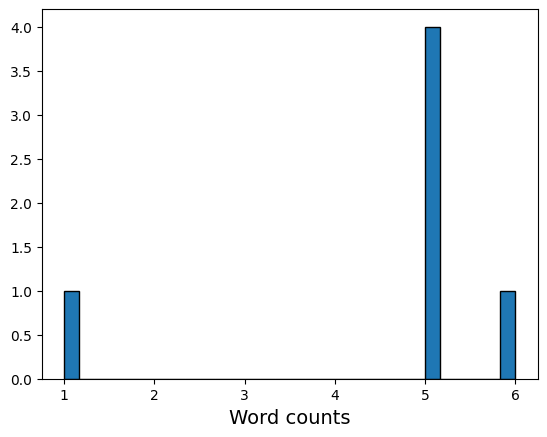

In [82]:
review_word_count_histgram(X_temp)

In [8]:
# delete those irrelevant variables
del X_temp, Vectorizer_temp, corpus_temp

In [13]:
X, y, vectorizer_BOW, text = create_bow_from_reviews('../datasets/yelp_reviews.json') 

Loading the file: ../datasets/yelp_reviews.json
Total number of reviews extracted = 20000
Extracting tokens from each review.....(can be slow for a large number of reviews)......
Data shape:  (17501, 404)


In [50]:
# this means there are 17501 documents, and 404 unique words
X.toarray().shape

(17501, 404)

- **Implement the function `review_word_count_histogram`, which generates a histogram to show how many unique words (from the vocabulary) are in each review. That is, for each review, count the number of unique words in the review, and plot a histogram illustrating these counts.**

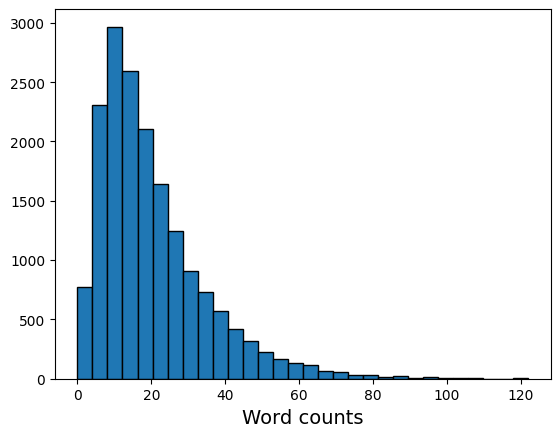

In [79]:
# Mark: the visualization here is problematic
def review_word_count_histgram(X):
    '''
    X:  [# feature vectors, # features], feature vectors
    '''
    ### YOUR CODE STARTS HERE ###
    fig, axes = plt.subplots()

    dens = np.sum(X > 0, axis=1) # get unique word density for each comment
    axes.hist(dens, bins=30, edgecolor='black')
    axes.set_xlabel('Word counts', fontsize=14)


    ###  YOUR CODE ENDS HERE  ###

review_word_count_histgram(X)

### Problem 2.3 (10 points): Fit a logistic regression classifier on Yelp dataset.

You will now build a logistic regression model to classify reviews as either negative or positive. In the code you are given, a training/testing split has already been created for you.

- Build a logistic classifier on the training subset. **Please use 'l1' `penality` type, 'liblinear' `solver` and enable `fit_intercept`.**
- Evaluate the accuracy of your model on the test subset.

**NOTE**: 
before starting this problem please read the scikit-learn documentation on [linear classifiers](https://scikit-learn.org/stable/modules/linear_model.html) and [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression).

In [ ]:
def logistic_classification(X, y): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
   
    print('Number of training examples: ', X_train.shape[0])
    print('Number of testing examples: ', X_test.shape[0])   
    print('Vocabulary size: ', X_train.shape[1]) 
    
    ### YOUR CODE STARTS HERE ###
    
    # Specify the logistic classifier model, 
    # Please use 'l1' penality type, 'liblinear' solver and enable fit_intercept
    classifier = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True).fit(X_train, y_train)
    
    # Compute and print accuracy on the test data
    test_predictions = classifier.predict(X_test)
    test_accuracy = np.mean(test_predictions == y_test)

    ###  YOUR CODE ENDS HERE  ###
    
    print('\nTesting accuracy:', format( 100*test_accuracy , '.2f') )
    
    return classifier

In [ ]:
logistic_classifier = logistic_classification(X, y)

Number of training examples:  12250
Number of testing examples:  5251
Vocabulary size:  404

Testing accuracy: 89.51


### Problem 2.4 (10 points): Find the top k most negative/most positive features

In this problem, you will complete the function `most_significant_terms`. This function will:

- print and return the most significant positive and negative weights of your logistic regresson model
- print and return the words associated with these weights.

The function `most_significant_terms` takes as input
- a scikit-learn trained logistic regression classifier (e.g., trained in Problem 2.3) 
- a scikit-learn vectorizer object that produced the BOW features for the classifier

and prints out
- the terms in the vocabulary tokens with the **top 10** largest positive weights  
- the terms in the vocabulary with the **top 10** smallest (i.e., largest in terms of absolute value) negative weights. For example, a weight of $-10$ is smaller than a weight of $-1$. 

Hint: Check the attributes section of the vectorizer documentation (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to find where the mapping between words and indices are located.

In [ ]:
def most_significant_terms(classifier, vectorizer, K):
    # cycle through the positive weights, in the order of largest weight first and print out
    # K lines where each line contains
    # (a) the term corresponding to the weight (a string)
    # (b) the weight value itself (a scalar printed to 3 decimal places)
    
    ### YOUR CODE STARTS HERE ###

    # extract coefficients from trained model and sort based on coefficient
    args = np.argsort(classifier.coef_[0])
    top_args = args[-K:][::-1]
    low_args = args[:K]
    vocab = {v : k for k, v in vectorizer.vocabulary_.items()}
    
    # extract topK positive terms
    topK_pos_terms = [ vocab[index] for index in top_args ]
    
    # extract corresponding weights
    topK_pos_weights = np.round(classifier.coef_[0][top_args], decimals=3)
    
    # extract topK negative terms
    topK_neg_terms = [ vocab[index] for index in low_args ]
    
    # extract corresponding weights
    topK_neg_weights = np.round(classifier.coef_[0][low_args], decimals=3)


    ###  YOUR CODE ENDS HERE  ###
    print('topK_pos_weights', topK_pos_weights)
    print('topK_pos_terms', topK_pos_terms)
    print('topK_neg_weights', topK_neg_weights)
    print('topK_neg_terms',topK_neg_terms)
    
    return (topK_pos_weights, topK_neg_weights, topK_pos_terms, topK_neg_terms)

In [ ]:
output = most_significant_terms(logistic_classifier, vectorizer_BOW, K=10)

topK_pos_weights [2.312 2.306 2.032 1.986 1.761 1.727 1.726 1.673 1.634 1.557]
topK_pos_terms ['unique', 'delicious', 'excellent', 'amazing', 'awesome', 'wonderful', 'thank', 'perfect', 'enjoyed', 'easy']
topK_neg_weights [-3.322 -1.544 -1.299 -1.269 -1.174 -1.109 -1.075 -0.903 -0.899 -0.857]
topK_neg_terms ['worst', 'okay', 'disappointed', 'tasted', 'ok', 'guess', 'won', 'maybe', 'slow', 'money']


 - What do you observe from the above output? Provide a short explanation for why you see what you see.

**[The top 10 positive weights are associated with positive words, and top 10 negative weights are associated with negative words. Because in a positive review, writer tends to use more positive words to describe than using negative words and vice versa.]**

### Problem 2.5 (10 points): Tune reguarlization parameter on Yelp dataset

In this problem, you will tune the regularization parameter of your logistic regression model in order to increase your accuracy.

- Complete the function `accuracy_vs_reg`. This function should perform L1 regularization using the values defined in the array 'cs' below. For every value of the regularization parameter in `cs`, you should store the resulting training accuracy in the list `train_accuracies` and the resulting testing accuracy in the list `test_accuracies`.
- Use your implementation to plot the curves of train/test accuracy vs regularization strength, for the Yelp data we used above. The plotting code necessary to do this is already given to you, and you only need to call the function.

In [ ]:
def accuracy_vs_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    # log initialization
    coefs_ = []
    train_accuracies = []
    test_accuracies = []
    cs = [0, 0.1, 1, 10, 50]
    
    ### YOUR CODE STARTS HERE ###
    for c in cs:
        
        # Specify the logistic classifier model
        if c == 0:
            classifier = LogisticRegression(penalty='none', fit_intercept=True)
        else:
            # Refer https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
            # to see which argument can adjust the regularization strength,
            # Additionally, please use 'l1' penalty type, 'liblinear' solver and enable fit_intercept
            classifier = LogisticRegression(penalty='l1', C=c, solver='liblinear', fit_intercept=True)
            
        classifier.fit(X_train, y_train)
        
        # log model coefficients
        coefs_.append(classifier.coef_[0])
        
        # log model training and test accuracies
        train_accuracies.append(classifier.score(X_train, y_train))
        test_accuracies.append(classifier.score(X_test, y_test))

    ###  YOUR CODE ENDS HERE  ###
    
    fig, axes = plt.subplots()
    axes.semilogx(cs, train_accuracies, color='red', label='training accuracy')
    axes.semilogx(cs, test_accuracies, color='blue', label='testing accuracy')
    
    axes.set_xlabel('regularization strength', fontsize=14)
    axes.set_ylabel('accuracy', fontsize=14)
    
    axes.legend()

    return train_accuracies, test_accuracies, coefs_

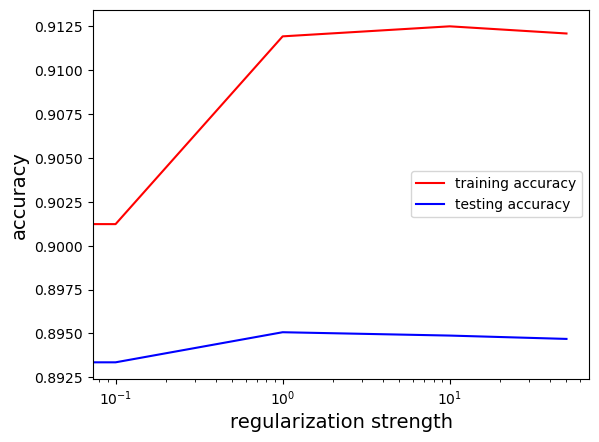

In [ ]:
train_accuracies, test_accuracies, coefs = accuracy_vs_reg(X, y)

- Choose a final value for the regularization parameter and justify your choice. You should choose a **single** value from the list `cs` given in the code above. 

**[The regularization parameter should be 1, because it has the highest accuracy on the testing data set.]**